# 使用Sequence to Sequence 模型，英翻中
### 程式修改自 [Character-level recurrent sequence-to-sequence model](https://keras.io/examples/nlp/lstm_seq2seq/)

In [1]:
# 載入相關套件
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential

## 參數設定

In [2]:
# 參數設定
batch_size = 64      # 訓練批量
epochs = 100         # 訓練執行週期
latent_dim = 256     # 隱藏層輸出維度
num_samples = 10000  # 訓練樣本數
data_path = "./RNN/fra.txt" # 訓練資料集檔案路徑

## 讀取訓練檔案，進行資料前置處理

In [3]:
# 整理兩種語言的字彙表
input_texts = []  # 原始語言
target_texts = [] # 目標語言
input_characters = set()  # 原始語言字母列表
target_characters = set() # 目標語言字母列表

# 讀取cmn.txt檔案
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

# 每列均以 tab 符號隔開，英文為input，中文為output    
for line in lines[: min(num_samples, len(lines) - 1)]:
    arr = line.split("\t")
    input_text, target_text = arr[0], arr[1]

    # 目標語言前面加 "\t"，後前面加 "\n"
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

## 統計筆數、字母、長度

In [4]:
# 統計筆數、字母、長度
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("原始語言筆數:", len(input_texts))
print("原始語言字母數:", num_encoder_tokens)
print("目標語言字母數:", num_decoder_tokens)
print("原始語言語句最大長度:", max_encoder_seq_length)
print("目標語言語句最大長度:", max_decoder_seq_length)

原始語言筆數: 10000
原始語言字母數: 71
目標語言字母數: 93
原始語言語句最大長度: 15
目標語言語句最大長度: 59


## 將字彙表轉為字典

In [5]:
# 將字彙表轉為字典資料型態
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

## 利用字典將原文轉為數字

In [6]:
# 利用字典將原文轉為數字
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder 輸出比輸入早一期
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
                    
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

## 建立模型

In [7]:
# 建立模型
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# 不使用 encoder 的輸出，只保留狀態(state)，即語意結構
encoder_states = [state_h, state_c]

# decoder 以 encoder 語意結構為輸入 
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# 傳回 LSTM 每一個輸出
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 71)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 93)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 335872      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  358400      input_2[0][0]                    
                                                                 lstm[0][1]                   

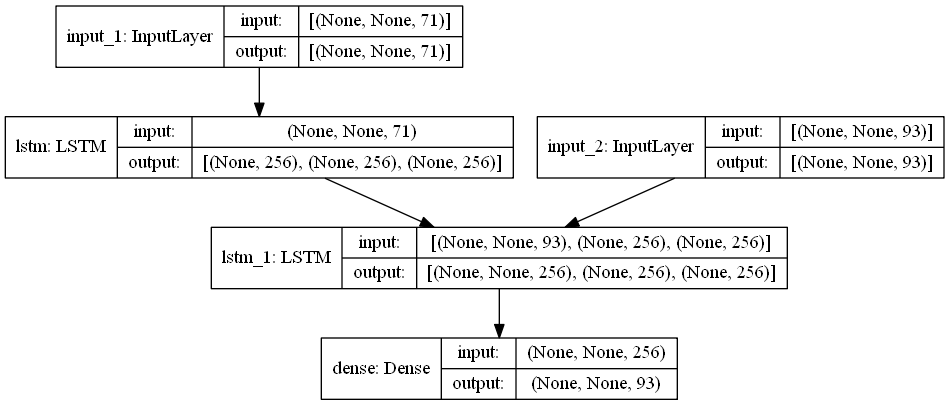

In [8]:
# 繪製模型
# show_shapes=True：Layer 含 Input/Output 資訊
keras.utils.plot_model(model, "nmt1.png", show_shapes=True)

## 訓練模型

In [9]:
# 訓練模型
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
# 模型存檔
model.save("nmt1.h5")

Epoch 1/100
125/125 [==============================] - 8s 37ms/step - loss: 1.5002 - accuracy: 0.7043 - val_loss: 1.0597 - val_accuracy: 0.7072
Epoch 2/100
125/125 [==============================] - 3s 24ms/step - loss: 0.8708 - accuracy: 0.7638 - val_loss: 0.8362 - val_accuracy: 0.7661
Epoch 3/100
125/125 [==============================] - 3s 24ms/step - loss: 0.6982 - accuracy: 0.8073 - val_loss: 0.6994 - val_accuracy: 0.7979
Epoch 4/100
125/125 [==============================] - 3s 23ms/step - loss: 0.5895 - accuracy: 0.8295 - val_loss: 0.6401 - val_accuracy: 0.8111
Epoch 5/100
125/125 [==============================] - 3s 23ms/step - loss: 0.5381 - accuracy: 0.8425 - val_loss: 0.6004 - val_accuracy: 0.8259
Epoch 6/100
125/125 [==============================] - 3s 24ms/step - loss: 0.5009 - accuracy: 0.8530 - val_loss: 0.5670 - val_accuracy: 0.8356
Epoch 7/100
125/125 [==============================] - 3s 24ms/step - loss: 0.4691 - accuracy: 0.8618 - val_loss: 0.5439 - val_accuracy:

125/125 [==============================] - 3s 24ms/step - loss: 0.0903 - accuracy: 0.9715 - val_loss: 0.5913 - val_accuracy: 0.8740
Epoch 58/100
125/125 [==============================] - 3s 23ms/step - loss: 0.0883 - accuracy: 0.9721 - val_loss: 0.5990 - val_accuracy: 0.8743
Epoch 59/100
125/125 [==============================] - 3s 24ms/step - loss: 0.0857 - accuracy: 0.9729 - val_loss: 0.6020 - val_accuracy: 0.8744
Epoch 60/100
125/125 [==============================] - 3s 24ms/step - loss: 0.0848 - accuracy: 0.9734 - val_loss: 0.6046 - val_accuracy: 0.8737
Epoch 61/100
125/125 [==============================] - 3s 24ms/step - loss: 0.0826 - accuracy: 0.9737 - val_loss: 0.6089 - val_accuracy: 0.8742
Epoch 62/100
125/125 [==============================] - 3s 24ms/step - loss: 0.0801 - accuracy: 0.9745 - val_loss: 0.6148 - val_accuracy: 0.8733
Epoch 63/100
125/125 [==============================] - 3s 24ms/step - loss: 0.0794 - accuracy: 0.9747 - val_loss: 0.6200 - val_accuracy: 0.873

## 預測
1. 對input編碼，取得解碼器的初起狀態
2. 執行解碼：將解碼器的初起狀態及原始輸入進行解碼
3. 重複執行，取得序列資料

In [10]:
# # 載入模型，非必要
# from os import path
# if path.exists("nmt1.h5"):
#     model = keras.models.load_model("nmt1.h5")

## 設定字典，可將整數轉回文字

In [11]:
# 取得 encoder 語意結構
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

# 取得 decoder 的目標語言輸入
decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_3")
decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# 設定字典，可將整數轉回文字
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

## 定義預測函數

In [12]:
# 預測函數
def decode_sequence(input_seq):
    # 取得狀態(語意結構)
    states_value = encoder_model.predict(input_seq)

    # 初始化 decoder 目標語言輸出
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # 設定目標語言第一個字母為起始字母
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # 預測
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        # 取得預測值
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 找到最大可能的字母
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # 如果整句翻完，即結束
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # 輸出
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # 更新狀態
        states_value = [h, c]
    return decoded_sentence

## 測試前50筆

In [13]:
encoder_input_data.shape

(10000, 15, 71)

In [14]:
# 測試前50筆
for seq_index in range(50):
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

Input sentence: Go.
Decoded sentence: Bouge !

Input sentence: Go.
Decoded sentence: Bouge !

Input sentence: Go.
Decoded sentence: Bouge !

Input sentence: Hi.
Decoded sentence: Salut !

Input sentence: Hi.
Decoded sentence: Salut !

Input sentence: Run!
Decoded sentence: Cours !

Input sentence: Run!
Decoded sentence: Cours !

Input sentence: Run!
Decoded sentence: Cours !

Input sentence: Run!
Decoded sentence: Cours !

Input sentence: Run!
Decoded sentence: Cours !

Input sentence: Run!
Decoded sentence: Cours !

Input sentence: Run!
Decoded sentence: Cours !

Input sentence: Run!
Decoded sentence: Cours !

Input sentence: Run.
Decoded sentence: Cours !

Input sentence: Run.
Decoded sentence: Cours !

Input sentence: Run.
Decoded sentence: Cours !

Input sentence: Run.
Decoded sentence: Cours !

Input sentence: Run.
Decoded sentence: Cours !

Input sentence: Run.
Decoded sentence: Cours !

Input sentence: Run.
Decoded sentence: Cours !

Input sentence: Run.
Decoded sentence: Cours 

## 自訂資料測試

In [15]:
# 自訂資料測試
test_data = ['Join us', 'It\'s me', 'Keep it']
encoder_input_data = np.zeros(
    (len(test_data), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)

for i, input_text in enumerate(test_data):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
        
for seq_index in range(encoder_input_data.shape[0]):
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("Input sentence:", test_data[seq_index])
    print("Decoded sentence:", decoded_sentence)

Input sentence: Join us
Decoded sentence: Dises simplement non !

Input sentence: It's me
Decoded sentence: C'est une chanson.

Input sentence: Keep it
Decoded sentence: Gardez les épaus.



In [25]:
import googletrans

translator = googletrans.Translator()

In [26]:
googletrans.LANGUAGES

{'af': 'afrikaans',
 'sq': 'albanian',
 'am': 'amharic',
 'ar': 'arabic',
 'hy': 'armenian',
 'az': 'azerbaijani',
 'eu': 'basque',
 'be': 'belarusian',
 'bn': 'bengali',
 'bs': 'bosnian',
 'bg': 'bulgarian',
 'ca': 'catalan',
 'ceb': 'cebuano',
 'ny': 'chichewa',
 'zh-cn': 'chinese (simplified)',
 'zh-tw': 'chinese (traditional)',
 'co': 'corsican',
 'hr': 'croatian',
 'cs': 'czech',
 'da': 'danish',
 'nl': 'dutch',
 'en': 'english',
 'eo': 'esperanto',
 'et': 'estonian',
 'tl': 'filipino',
 'fi': 'finnish',
 'fr': 'french',
 'fy': 'frisian',
 'gl': 'galician',
 'ka': 'georgian',
 'de': 'german',
 'el': 'greek',
 'gu': 'gujarati',
 'ht': 'haitian creole',
 'ha': 'hausa',
 'haw': 'hawaiian',
 'iw': 'hebrew',
 'he': 'hebrew',
 'hi': 'hindi',
 'hmn': 'hmong',
 'hu': 'hungarian',
 'is': 'icelandic',
 'ig': 'igbo',
 'id': 'indonesian',
 'ga': 'irish',
 'it': 'italian',
 'ja': 'japanese',
 'jw': 'javanese',
 'kn': 'kannada',
 'kk': 'kazakh',
 'km': 'khmer',
 'ko': 'korean',
 'ku': 'kurdish 

In [27]:
results = translator.translate('Join us', src='en', dest='fr')
print(results.text)

AttributeError: 'NoneType' object has no attribute 'group'